In [ ]:
! pip install bnunicodenormalizer

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
from bnunicodenormalizer import Normalizer



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url='/content/drive/MyDrive/Colab Notebooks/sentiment-analysis/dataset.csv'
df=pd.read_csv(url)
df.head()

,text,label
0,অসাধারণ নিশো বস্ আর অমি ভাইকেও।,positive
1,আমার দেখা বেস্ট নাটক,positive
2,"নাটক টা অনেক সুন্দর হয়েছে,,,,আফরান নিশো ভাইয়...",positive
3,সত্যি অসাধারণ একটি রিলেশন,positive
4,মজা পাইছি ভাষা গুলো কেমন লাগলো,positive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    # Normalize text using bnunicodenormalizer (Normalize different forms of similar characters)
    #normalizer = Normalizer()
    #text = normalizer.normalize(text)

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(f"[{string.punctuation}]", "", text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove extra whitespace
    text = text.strip()

    # Remove special characters and non-Bengali characters
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)

    # Correct common spelling variations (if any specific patterns are known)
    text = re.sub(r'ব্যাপক', 'বেশি', text)  # Example: correct 'ব্যাপক' to 'বেশি'

    # Tokenize the text (split into words)
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('bengali'))
    tokens = [word for word in tokens if word not in stop_words]

    # Optionally, apply lemmatization (if a suitable library is available)

    # Rejoin tokens into a single string
    text = " ".join(tokens)

    return text
df["text"] = df["text"].apply(preprocess_text)

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label']) # positive -> 1, negative -> 0

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
# Save the DataFrame to a CSV file in Google Colab
df.to_csv('preprocessed_data.csv', index=False)

print("CSV file created successfully.")

CSV file created successfully.


In [ ]:
from google.colab import files

# Download the CSV file
files.download('preprocessed_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The fit_on_texts method is used to build the internal vocabulary index based on the texts in df['text']. This method:

Builds Vocabulary: Maps each unique word in the dataset to a unique integer. This is done by creating a word-to-index dictionary where words are assigned integer indices.
Counts Words: Counts the occurrences of each word in the dataset, which can be useful for understanding word frequencies.

In [ ]:
# Pad sequences to ensure uniform input length
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

# Prepare labels
y = to_categorical(df['label'])

The pad_sequences function is used to ensure that all sequences in the dataset have the same length. This is important for feeding data into machine learning models, especially neural networks that expect inputs of uniform size.

maxlen: Specifies the desired length of the sequences. If a sequence is shorter than maxlen, it will be padded with zeros at the beginning (by default). If it is longer, it will be truncated from the beginning to fit maxlen.
X: The result is an array where all sequences have been padded or truncated to the length specified by maxlen.

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
from sklearn.linear_model import PassiveAggressiveClassifier

# Convert y_train and y_test from one-hot encoded format to class labels (1D arrays)
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)




In [ ]:
# Initialize the PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=50)

# Train the model with the converted labels
pac.fit(X_train, y_train_labels)

# Predict on the test data
y_pred_passive = pac.predict(X_test)


Accuracy: 0.51
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.39      0.31       649
           1       0.71      0.56      0.62      1713

    accuracy                           0.51      2362
   macro avg       0.48      0.47      0.46      2362
weighted avg       0.58      0.51      0.54      2362

Confusion Matrix:
[[253 396]
 [756 957]]


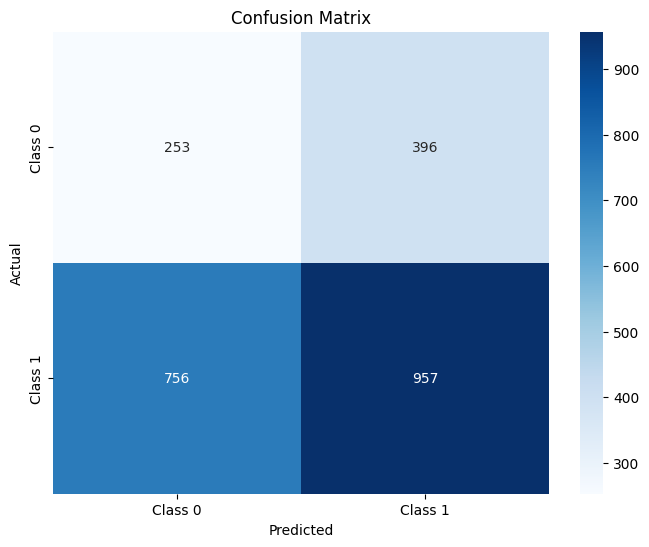

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred_passive)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_passive))

# Generate and print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_passive))

# Visualize the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_passive)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
model.add(SimpleRNN(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

vocab_size: The size of the vocabulary is calculated based on the number of unique words in the tokenizer’s word index. Adding 1 accounts for the reserved index 0 which is used for padding.

input_dim: The size of the vocabulary. This layer will learn vocab_size distinct embeddings.
output_dim: The dimensionality of the embedding vectors (128 in this case). Each word will be represented as a 128-dimensional vector.
input_length: The length of input sequences (maxlen), ensuring the input shape matches the model's expected input.



128: The number of units in the RNN layer. This controls the dimensionality of the output space.
return_sequences=False: Only the last output of the RNN will be returned. For many tasks, we’re interested in the final output rather than all intermediate outputs.

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.6939 - loss: 0.5942 - val_accuracy: 0.8912 - val_loss: 0.2702
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - accuracy: 0.9375 - loss: 0.1843 - val_accuracy: 0.9052 - val_loss: 0.2323
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.9813 - loss: 0.0572 - val_accuracy: 0.9141 - val_loss: 0.2538
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9917 - loss: 0.0336 - val_accuracy: 0.9128 - val_loss: 0.2983
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - accuracy: 0.9937 - loss: 0.0204 - val_accuracy: 0.9047 - val_loss: 0.3490
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.9963 - loss: 0.0184 - val_accuracy: 0.9039 - val_loss: 0.4197
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9963 - loss: 0.0107 - val_accuracy: 0.9009 - val_loss: 0.4628
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9920 - loss: 0.02

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9196 - loss: 0.3407
Test Accuracy: 91.87%


In [ ]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


np.argmax(y_pred, axis=1): Converts the probabilities predicted by the model into class labels.
y_pred: A 2D array where each row corresponds to a sample, and each column corresponds to a class probability.
axis=1: Specifies that the argmax function should operate along the columns (i.e., across the class probabilities) to find the index (class label) with the highest probability for each sample.
y_pred_classes: Contains the predicted class labels for each sample. It is a 1D array where each entry is the index of the class with the highest probability.


np.argmax(y_test, axis=1): Converts one-hot encoded true labels into class labels.
y_test: A 2D array where each row is a one-hot encoded vector representing the true class.
axis=1: Finds the index of the class with a value of 1 (the correct class) for each sample.
y_true: Contains the true class labels for each sample. It is a 1D array where each entry is the index of the class corresponding to the true label.

In [ ]:
# Generate a classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['Negative', 'Positive']))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.84      0.88      0.86       649
    Positive       0.95      0.94      0.94      1713

    accuracy                           0.92      2362
   macro avg       0.89      0.91      0.90      2362
weighted avg       0.92      0.92      0.92      2362



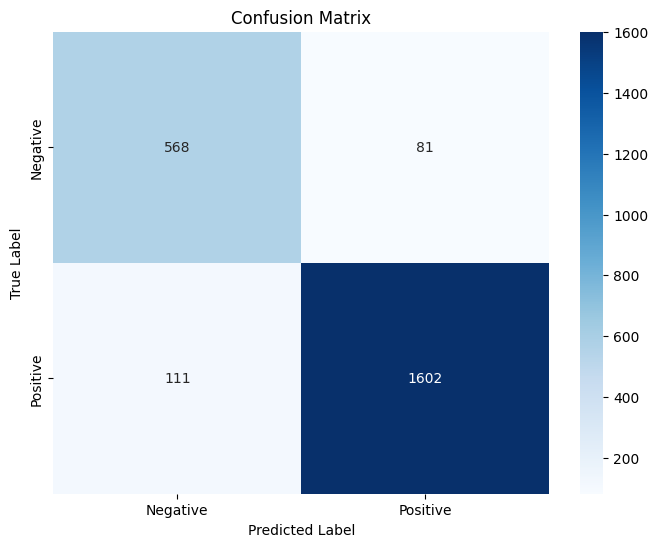

In [ ]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the model
model.save('rnn_model.h5')

# Download the model file
files.download('rnn_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Hyperparameter

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming x_train and y_train are your original training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
! pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense

# Define a function to build the RNN model with hyperparameters
def build_model(hp):
    model = Sequential()
    vocab_size = len(tokenizer.word_index) + 1
    maxlen = hp.Int('maxlen', min_value=50, max_value=300, step=50)

    # Embedding layer
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embedding_dim', values=[64, 128, 256]),
        input_length=maxlen
    ))

    # RNN layer
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', min_value=64, max_value=256, step=64),
        return_sequences=False
    ))

    # Dropout layer
    model.add(Dropout(hp.Float('dropout_rate_1', min_value=0.3, max_value=0.7, step=0.1)))

    # Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))

    # Dropout layer
    model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.3, max_value=0.7, step=0.1)))

    # Output layer for binary classification
    model.add(Dense(2, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train for each combination
    directory='hyperparameter_tuning',
    project_name='rnn_tuning'
)

# Fit the tuner
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()


Trial 5 Complete [00h 06m 03s]
val_accuracy: 0.9147697389125824

Best val_accuracy So Far: 0.9224457442760468
Total elapsed time: 00h 45m 27s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 256)            │       4,364,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 192)                 │          86,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 96)                  │          18,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             194 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,469,218 (17.05 MB)

 Trainable params: 4,469,218 (17.05 MB)

 Non-trainable params: 0 (0.00 B)

1. Model Building Function (build_model)
hp: The hp parameter is a HyperParameters object that allows you to define a range of values for various hyperparameters. Keras Tuner will try different combinations within these ranges to find the optimal set.
Embedding Layer:
The embedding layer converts integer-encoded words into dense vectors of fixed size.
vocab_size: The size of the vocabulary, determined by the tokenizer.
output_dim: The dimensionality of the embedding vectors, chosen from [64, 128, 256].
input_length: The maximum sequence length, which is a tunable parameter (maxlen) between 50 and 300, with steps of 50.
SimpleRNN Layer:
The RNN layer processes sequences of vectors (from the embedding layer).
units: The number of RNN units is a tunable parameter between 64 and 256, with steps of 64.
return_sequences=False: Only the last output in the sequence is returned, which is common for many-to-one sequence tasks like classification.
Dropout Layers:
Dropout layers help prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
Two dropout layers are used, with tunable dropout rates between 0.3 and 0.7, with steps of 0.1.
Dense Layer:
The dense layer is fully connected, with tunable units between 32 and 128, with steps of 32.
It uses the ReLU activation function, which is a common choice for hidden layers.
Output Layer:
The output layer has 2 units with a sigmoid activation function, designed for binary classification.
2. Compiling the Model
Optimizer: The model uses the Adam optimizer, which is adaptive and widely used.
Loss Function: The loss function is categorical_crossentropy, which is suitable for multi-class classification problems. However, since this is a binary classification problem, you might want to use binary_crossentropy instead.
3. Hyperparameter Tuning (RandomSearch)
Objective: The tuner aims to maximize val_accuracy, meaning it will seek the hyperparameters that give the best validation accuracy.
max_trials=5: The tuner will try 5 different combinations of hyperparameters.
executions_per_trial=2: Each combination of hyperparameters will be tried twice to ensure consistency in results.
4. Fitting the Tuner
The tuner searches for the best hyperparameter combination by fitting the model on X_train and y_train, and validating on X_val and y_val for 10 epochs.
5. Retrieving the Best Model
After the search is complete, the best model is retrieved using tuner.get_best_models(num_models=1)[0].
The summary of the best model can be printed using best_model.summary().

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9203 - loss: 0.2357
Test Loss: 0.23299165070056915
Test Accuracy: 0.9246401190757751


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict classes for the test set
y_pred_probs = best_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded y_test back to class labels if needed
y_test_labels = y_test.argmax(axis=1)



74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


In [ ]:
# Calculate and print the classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       649
           1       0.94      0.95      0.95      1713

    accuracy                           0.92      2362
   macro avg       0.91      0.90      0.90      2362
weighted avg       0.92      0.92      0.92      2362



In [ ]:
# Calculate and print the confusion matrix
print("Confusion Matrix:")
cm=confusion_matrix(y_test_labels, y_pred)
print(confusion_matrix(y_test_labels, y_pred))


Confusion Matrix:
[[ 553   96]
 [  82 1631]]


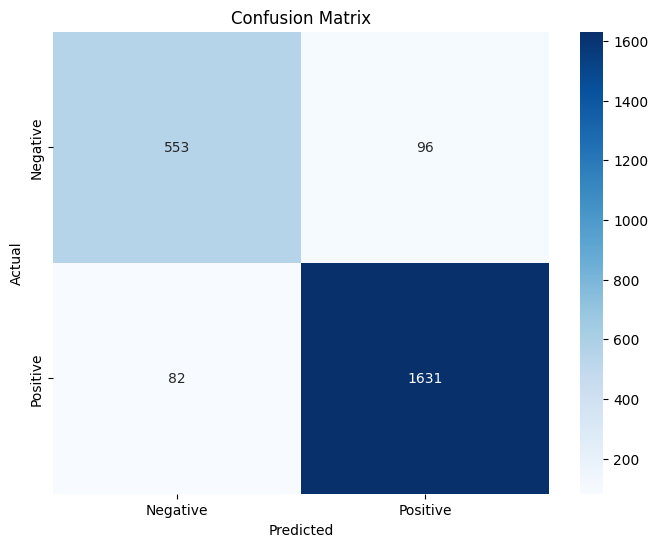

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pickle
from google.colab import files

# Save the tokenizer to a pickle file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Download the tokenizer pickle file
files.download('tokenizer.pickle')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the model
model.save('best_model.h5')

# Download the model file
files.download('best_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>